In [34]:
import warnings; warnings.simplefilter('ignore')

This notebook requires access to OpenAI API to run.
## 1. Data

In [35]:
from orion.data import load_signal

data = load_signal('exchange-2_cpm_results')
data.shape

(1624, 2)

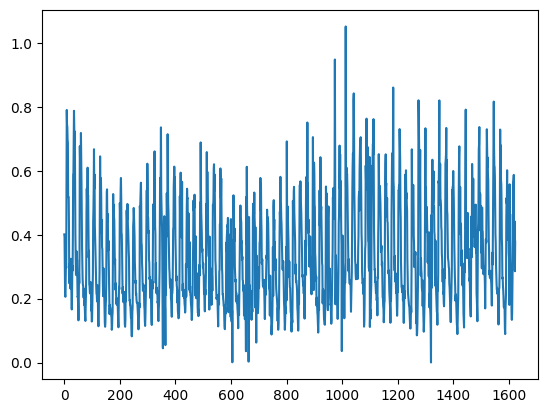

In [36]:
import matplotlib.pyplot as plt

plt.plot(data['value']);

if you want a quick test of how this pipeline works, uncomment the cell below to save time. We will look at a small segment of the time series.

In [37]:
# start = 900
# end = start + 200

# data = data.iloc[start: end]

# plt.plot(data['value']);

## 2. Pipeline

In [38]:
from mlblocks import MLPipeline
pipeline = MLPipeline('gpt_prompter')

In [39]:
hyperparameters = {
    "mlstars.custom.timeseries_preprocessing.time_segments_aggregate#1": {
        "interval": 3600
    }, 
    "sigllm.primitives.prompting.anomalies.find_anomalies_in_windows#1": {
        "alpha": 0.5
    },
    "sigllm.primitives.prompting.anomalies.merge_anomalous_sequences#1": {
        "beta": 0.5
    }
}

pipeline.set_hyperparameters(hyperparameters)

### step-by-step execution

MLPipelines are compose of a squence of primitives, these primitives apply tranformation and calculation operations to the data and updates the variables within the pipeline. To view the primitives used by the pipeline, we access its primtivies attribute.

The mistral-detector contains 10 primitives. we will observe how the context (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [40]:
pipeline.primitives

['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'sigllm.primitives.transformation.Float2Scalar',
 'sigllm.primitives.prompting.timeseries_preprocessing.rolling_window_sequences',
 'sigllm.primitives.transformation.format_as_string',
 'sigllm.primitives.prompting.gpt.GPT',
 'sigllm.primitives.transformation.format_as_integer',
 'sigllm.primitives.prompting.anomalies.val2idx',
 'sigllm.primitives.prompting.anomalies.find_anomalies_in_windows',
 'sigllm.primitives.prompting.anomalies.merge_anomalous_sequences',
 'sigllm.primitives.prompting.anomalies.format_anomalies']

#### time segment aggerate
this primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    * `X` sequence of aggregated values, one column for each aggregation method.
    * `timestamp` sequence of timestamp values.

In [41]:
step = 0
context = pipeline.fit(data, start_=step, output_=step)
context.keys()

dict_keys(['X', 'timestamp'])

In [42]:
for i, x in list(zip(context['timestamp'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1309471201 has value [0.4010481]
entry at 1309474801 has value [0.39271888]
entry at 1309478401 has value [0.30999612]
entry at 1309482001 has value [0.21293855]
entry at 1309485601 has value [0.20580091]


In [43]:
context['X'].shape

(1648, 1)

#### Single Imputer
this primitive is an imputation transformer for filling missing values.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `y` which is a transformed version of `X`.

In [44]:
step = 1
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'X'])

#### Float2Scalar
this primitive converts float values into scalar up to certain decimal points.

* **input**: `y` which is an n-dimensional sequence of values in float type.
* **output**: `X` which is a transformed version of `y` in scalar.

In [45]:
step = 2
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'X', 'minimum', 'decimal'])

In [46]:
for i, x in list(zip(context['timestamp'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1309471201 has value [40]
entry at 1309474801 has value [39]
entry at 1309478401 has value [30]
entry at 1309482001 has value [21]
entry at 1309485601 has value [20]


In [47]:
context['minimum']

0.000385004945833

#### Rolling Window
this primitive generates many sub-sequences of the original sequence. it uses a rolling window approach to create the sub-sequences out of time series data.
* **input**: `X` which is an 1-dimensional sequence to iterate over
* **output**: 
    * `X` input sequences
    * `first_index`: first index value of each input sequences

In [48]:
step = 3
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'minimum', 'decimal', 'X', 'first_index', 'window_size', 'step_size'])

In [49]:
# after slicing X into multiple sub-sequences
# we obtain a 3 dimensional matrix X where
# the shape indicates (# slices, window size, 1)

print("X shape = {}\nTimestamp shape = {}\nFirst index shape = {}".format(
    context['X'].shape, context['timestamp'].shape, context['first_index'].shape))

X shape = (37, 200, 1)
Timestamp shape = (1648,)
First index shape = (37,)


#### Format as string
this primitive converts each sequence of scalar values into string. 
* **input**: `X` which is an n-dimensional sequence of values
* **output**: `X_str` which is a string representation version of X

In [50]:
step = 4
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'minimum', 'decimal', 'first_index', 'window_size', 'step_size', 'X', 'X_str'])

In [51]:
context['X_str'].flatten().tolist()[0]

'4 0 , 3 9 , 3 0 , 2 1 , 2 0 , 2 5 , 3 0 , 2 9 , 5 3 , 7 8 , 7 4 , 7 3 , 6 9 , 6 8 , 5 1 , 5 1 , 5 1 , 4 1 , 2 4 , 3 0 , 2 7 , 2 6 , 2 3 , 2 6 , 3 2 , 2 5 , 2 1 , 1 6 , 2 1 , 3 0 , 2 8 , 3 9 , 5 8 , 5 9 , 7 1 , 7 8 , 7 3 , 6 8 , 7 2 , 5 2 , 4 0 , 3 4 , 2 7 , 2 7 , 3 4 , 2 8 , 3 2 , 2 5 , 2 0 , 2 0 , 1 7 , 1 3 , 1 7 , 2 7 , 2 4 , 3 4 , 6 7 , 6 2 , 6 0 , 5 9 , 7 1 , 6 3 , 5 6 , 4 3 , 3 6 , 3 0 , 2 6 , 2 4 , 2 4 , 2 0 , 2 0 , 2 3 , 1 7 , 1 9 , 1 6 , 1 4 , 1 2 , 1 6 , 2 1 , 2 8 , 4 7 , 5 4 , 5 0 , 5 3 , 6 0 , 5 1 , 5 2 , 4 2 , 3 2 , 3 4 , 2 4 , 2 4 , 2 1 , 2 1 , 2 2 , 2 5 , 2 2 , 1 6 , 1 7 , 1 2 , 1 3 , 1 7 , 2 2 , 2 7 , 4 4 , 4 7 , 5 4 , 6 6 , 5 4 , 5 8 , 4 2 , 3 9 , 3 6 , 3 2 , 2 7 , 2 3 , 2 1 , 2 1 , 1 9 , 2 4 , 2 2 , 1 9 , 1 3 , 1 1 , 1 5 , 2 0 , 2 2 , 2 8 , 4 7 , 6 4 , 5 2 , 5 7 , 5 7 , 5 1 , 4 0 , 4 4 , 3 6 , 3 5 , 2 8 , 2 4 , 2 0 , 2 9 , 2 1 , 2 2 , 2 1 , 1 6 , 1 2 , 1 1 , 1 2 , 1 7 , 1 9 , 2 4 , 4 0 , 5 3 , 5 4 , 4 3 , 4 6 , 4 3 , 3 4 , 3 8 , 3 2 , 2 5 , 2 2 , 1 5 , 1 8 , 1 7 , 1 7

In [52]:
type(context['X_str'][0][0])

str

when inspecting the time series, we can see that we have a single list consisting of 200 values (according the set `window_size`) and it is now of string type, ready to be an input to an LLM.

#### GPT
this primitive prompts a gpt model to detect the anomalies
* **input**: `X_str` input sequence
* **output**: `y_hat` detected anomalous values

In [53]:
step = 5
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

100%|███████████████████████████████████████████| 37/37 [01:04<00:00,  1.74s/it]


dict_keys(['timestamp', 'minimum', 'decimal', 'first_index', 'window_size', 'step_size', 'X_str', 'X', 'y_hat'])

In [54]:
len(context['y_hat']), len(context['y_hat'][0])

(37, 10)

#### format as integer
this primitive converts each sequences of string values into integers.
* **input**: `y_hat` which is a sequence of string values
* **output**: `y` which is an integer representation version of `y_hat`

In [55]:
step = 6
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'minimum', 'decimal', 'first_index', 'window_size', 'step_size', 'X_str', 'y_hat', 'X', 'y'])

In [56]:
context['y'].shape

(37, 10)

#### Val2Idx
this primitive converts integer values into indices they appear in the sequence
* **input**: 
    * `y` sequences of anomalous values
    * `X` input sequences
* **output**: 
    * `y` sequences of anomalous indices

In [57]:
step = 7
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'minimum', 'decimal', 'first_index', 'window_size', 'step_size', 'X_str', 'y_hat', 'X', 'y'])

In [58]:
context['y'].shape

(37, 10)

#### find_anomalies_in_windows
* **input**: `y` n-dimensional array of multiple anomalous indices sequences
* **output**: `y` array of each window's anomalous indices sequences

In [59]:
step = 8
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'minimum', 'decimal', 'first_index', 'window_size', 'step_size', 'X_str', 'y_hat', 'X', 'y'])

In [60]:
context['y'].shape

(37,)

#### merge_anomalous_sequences
* **input**: 
    * `y` array of each window's anomalous indices sequences
    * `first_index` first indices of input sequences
    * `window_size` size of each window
    * `step_size` step of rolling windows
* **output**: 
    * `y` anomalous indices of the input timeseries

In [61]:
step = 9
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'minimum', 'decimal', 'first_index', 'window_size', 'step_size', 'X_str', 'y_hat', 'X', 'y'])

In [62]:
context['y'].shape

(11,)

#### format_anomalies
* **input**: 
    * `y` sequence of anomalous indices
    * `timestamp` sequence of timestamp of the input series
* **output**:
    * `anomalies` array containing start-index, end-index, score for each anomalous sequence that was found

In [63]:
step = 10
context = pipeline.fit(**context, start_=step, output_=step)
context.keys()

dict_keys(['timestamp', 'minimum', 'decimal', 'first_index', 'window_size', 'step_size', 'X_str', 'y_hat', 'X', 'y', 'anomalies'])

In [64]:
context['anomalies']

[(1310162401, 1310529601, 0),
 (1311472801, 1312142401, 0),
 (1312178401, 1312538401, 0),
 (1312948801, 1313308801, 0),
 (1313877601, 1314241201, 0),
 (1314399601, 1314759601, 0)]

In [65]:
import pandas as pd

pd.DataFrame(context['anomalies'], columns=['start', 'end', 'score'])

,start,end,score
0,1310162401,1310529601,0
1,1311472801,1312142401,0
2,1312178401,1312538401,0
3,1312948801,1313308801,0
4,1313877601,1314241201,0
5,1314399601,1314759601,0


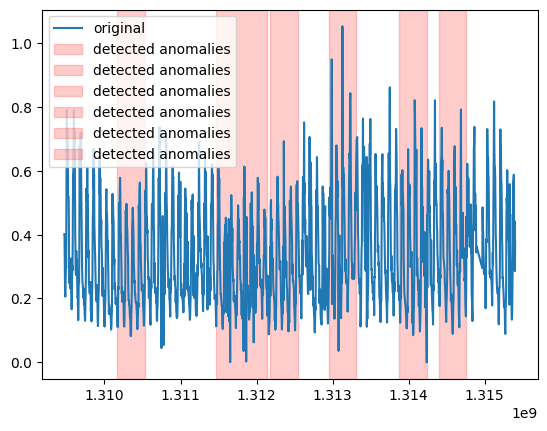

In [72]:
index, anomalies = list(map(context.get, ['timestamp', 'anomalies']))

plt.plot(data['timestamp'], data['value'], label='original')

for ano in anomalies:

    plt.axvspan(*ano[:2], color='r', alpha=0.2, label='detected anomalies')
plt.legend();